# Machine Learning Engineer Nanodegree
## Capstone Project : DeepTesla
March 18st, 2017

## Definition
### Project Overview

This project is based on Course [MIT 6.S094: Deep Learning for Self-Driving Cars](http://selfdrivingcars.mit.edu/deeptesl/)


### Problem Statement

This project is an end-to-end learning problem. The goal is to predict the steering wheel angel from Tesla dataset based on the video of the forward roadway.

### Datasets and Inputs

Databases with real-traffic video data captured and extracted 10 video clips of highway driving from Tesla:

- The wheel value was extracted from the in-vehicle CAN

- A window from each video frame is cropped/extracted and provide a CSV linking the window to a wheel value.

A snapshot of video frame:
<img src="./images/img/frame_1173.jpg" width = "320" height = "180" align=center />
    
The CSV data format:


|  ts_micro         | frame_index | wheel |
|:-----------------:|:-----------:|:-----:|
|  1464305394391807 | 0           | -0.5  |
| 1464305394425141  | 1           | -0.5  | 
| 1464305394458474  | 2           | -0.5  |


### Evaluation Metrics

This is a regression problem, MSE metrics is adopted here.

$$MSE = \frac{1}{N} \sum_{N}^{i=1}\sqrt{y_{p} - y}$$
where, $y_p$ is the predicted steering wheel angle, $y$ denotes the reference steering wheel angle, and the sample number is `N`. The lower MSE is preferred.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [2]:
# Import local env
import params, preprocess

data_dir = params.data_dir
out_dir = params.out_dir
model_dir = params.model_dir
img_dir = os.path.abspath('./images/img/')

img_height = params.img_height
img_width = params.img_width
img_channels = params.img_channels
batch_size = params.batch_size
num_classes = 1 # Regression problem

### Steering wheel angle

In [3]:
import glob
csv_files = glob.glob(os.path.join(data_dir, "*steering.csv"))
steering_csv = pd.concat((pd.read_csv(f) for f in csv_files))

In [4]:
steering_csv[-3:]

,frame,frame_index,ts_micro,wheel
2697,NaN,2697.0,1464305484291807,1.5
2698,NaN,2698.0,1464305484325141,1.5
2699,NaN,2699.0,1464305484358474,1.5


In [5]:
steering_csv.describe()

,frame,frame_index,ts_micro,wheel
count,5400.000000,21600.000000,2.700000e+04,27000.000000
mean,1616.166667,1349.500000,1.464374e+15,-0.338667
std,1120.991308,779.440853,1.382617e+11,4.438301
min,0.000000,0.000000,1.464304e+15,-18.000000
25%,674.750000,674.750000,1.464304e+15,-2.500000
50%,1349.500000,1349.500000,1.464305e+15,0.000000
75%,2549.250000,2024.250000,1.464306e+15,1.500000
max,3899.000000,2699.000000,1.464650e+15,15.000000


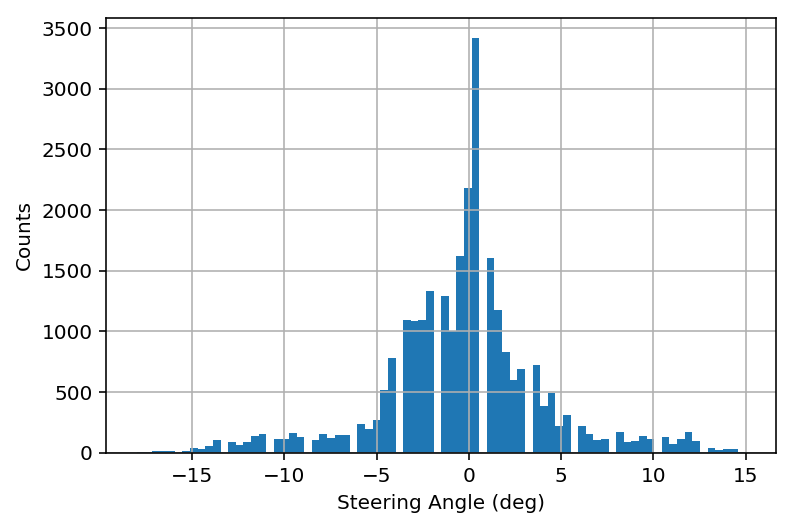

In [6]:
wheel = steering_csv['wheel']
plt.figure
plt.hist(wheel,80);
plt.xlabel('Steering Angle (deg)')
plt.ylabel('Counts')
#plt.title('Histogram of Steering Angle')
plt.grid(True)
plt.savefig(img_dir + "/Hist.png")

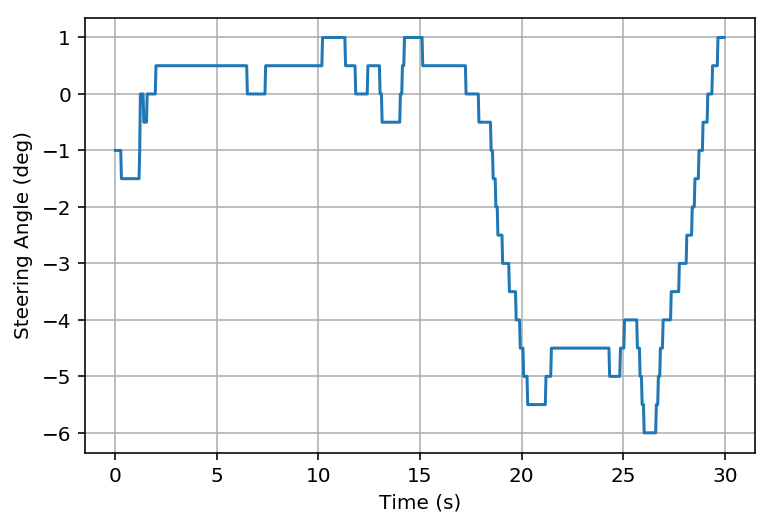

In [8]:
plt.figure;
plt.plot(np.arange( 0, 30, 1/30),wheel[:900]);
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (deg)')
plt.grid(True)
plt.savefig(img_dir + "/steering_angle.png")
plt.show()

### Video Info

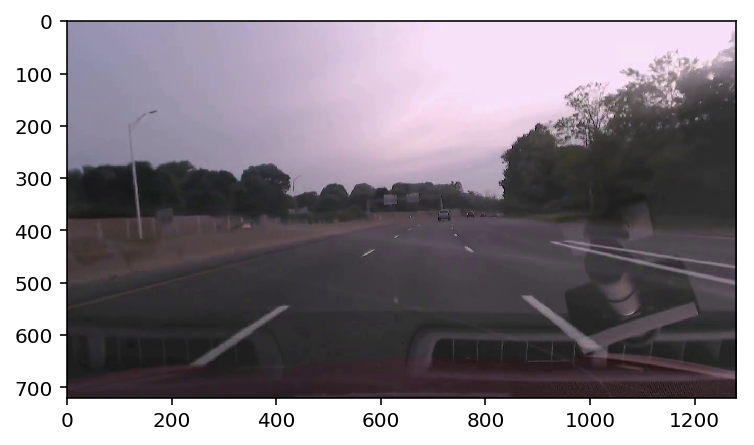

In [9]:
import matplotlib.image as mpimg
img=mpimg.imread("images/img/frame_1173.jpg")
imgplot = plt.imshow(img)

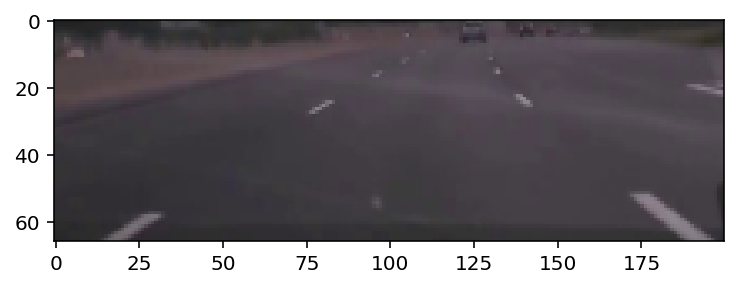

In [10]:
img = preprocess.preprocess(img)
imgplot = plt.imshow(img)

In [11]:
cap = cv2.VideoCapture("epochs/epoch03_front.mkv")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = int(cap.get(cv2.CAP_PROP_FPS))

print (length,width,height,fps)

2702 1280 720 30


The frame count of video is large than csv 2 frame counts

- Merge all frames together with corresponding steering wheel angle.
- Show one frame of the preprocessed data.

## Data Preprocessing 

### Train data

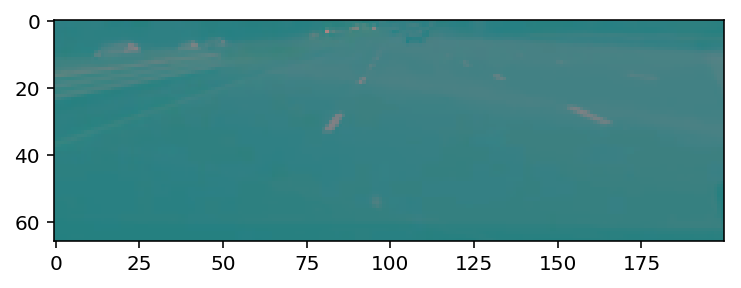

In [12]:
# Load epoches 1-9 as train data
imgs_data, wheels_data = preprocess.load_data('train', 'YUV')
plt.imshow(imgs_data[1])

In [13]:
# Transfer datatype
imgs_data = np.array(imgs_data)
wheels_data = np.array(wheels_data)
wheels_data = np.reshape(wheels_data,(len(wheels_data),1))

wheels_data.shape, imgs_data.shape

((24300, 1), (24300, 66, 200, 3))

### Test data

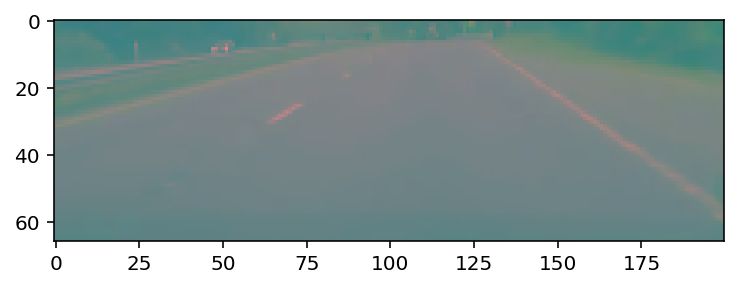

In [14]:
imgs_test, wheels_test = preprocess.load_data('test', 'YUV')
plt.imshow(imgs_test[1])

In [15]:
imgs_test = np.array(imgs_test)
wheels_test = np.array(wheels_test)
wheels_test = np.reshape(wheels_test,(len(wheels_test),1))

imgs_test.shape, wheels_test.shape

((2700, 66, 200, 3), (2700, 1))

In [16]:
# Save train data into a pickle file.
import pickle
pickle.dump(imgs_data, open('data_imgs_train.p', 'wb'))
pickle.dump(wheels_data, open('data_wheels_train.p', 'wb'))

# Save test data into a pickle file.
pickle.dump(imgs_test, open('data_imgs_test.p', 'wb'))
pickle.dump(wheels_test, open('data_wheels_test.p', 'wb'))

## Checkpoint

In [17]:
# Load data back from the pickle file.
import pickle
imgs_data = pickle.load(open('data_imgs_train.p', 'rb'))
wheels_data = pickle.load(open('data_wheels_train.p', 'rb'))

imgs_test = pickle.load(open('data_imgs_test.p', 'rb'))
wheels_test = pickle.load(open('data_wheels_test.p', 'rb'))

In [18]:
# Check the data dimension
print(imgs_data.shape, wheels_data.shape)
print(imgs_test.shape, wheels_test.shape)

(24300, 66, 200, 3) (24300, 1)
(2700, 66, 200, 3) (2700, 1)


In [30]:
def split_data_set(x, y, test_size, shuffle=False):
    '''Split into train and valid sets with shuffle or order'''
    if shuffle:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(x, y, test_size, random_state=42)
    else:
        split_point = int(len(wheels_data) * (1-test_size))
        X_train, X_val = x[:split_point], x[split_point:]
        y_train, y_val = y[:split_point], y[split_point:]
    return X_train, X_val, y_train, y_val

In [31]:
# Split data into train and valid sets
X_train, X_val, y_train, y_val = split_data_set(imgs_data, wheels_data, test_size=0.2)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'Valid samples')

X_train shape: (19440, 66, 200, 3)
19440 train samples
4860 Valid samples


## Keras Implementation

In [21]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import losses, regularizers

Using TensorFlow backend.


### Benchmark model

In [32]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(19440, 66, 200, 3) (4860, 66, 200, 3) (19440, 1) (4860, 1)


In [33]:
# NVIDIA model
def nvidia_model(img_height, img_width, img_channels):
    '''The nvidia_model.
    Input: img_height, img_width, img_channels'''
    model = Sequential()
    # Normalization
    model.add(Lambda(lambda x: x/255., 
                     input_shape=(img_height, img_width, img_channels)))
    # Cov layers
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    activation='relu'))
    # Fullyconnected layer
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [34]:
base_model = nvidia_model(img_height, img_width, img_channels)
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
__________

In [ ]:
time_start = time.time()
# Fit the model
base_history = base_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=10, 
                         batch_size=128)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

Train on 19440 samples, validate on 4860 samples
Epoch 1/10
19440/19440 [==============================] - 120s - loss: 22.7901 - val_loss: 15.7780

In [ ]:
# list all data in history
print(base_history.history.keys())
# summarize history for accuracy
plt.plot(base_history.history['mean_absolute_error'])
plt.plot(base_history.history['val_mean_absolute_error'])
# plt.title('Mean absolute error') 
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/base_mae.png")
plt.show()
# summarize history for loss
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/base_loss.png")
plt.show()

In [ ]:
print(base_model.summary())

### Implementation

In [ ]:
from keras.models import load_model
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# If the model exists, load model from h5:
read_model = True
if read_model:
    if os.path.isfile(model_saved_path):
        model = load_model(model_saved_path)

In [ ]:
epochs = 10

In [ ]:
# Build model
model = Sequential()

# Conv layers
model.add(Conv2D(32, (3, 3),  
                 activation='relu', 
                 input_shape=(img_height, img_width, img_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, (3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))

model.compile(loss=losses.mean_squared_error, optimizer='Adam', metrics=['mae'])

In [ ]:
time_start = time.time()
# Fit the model
history = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=epochs, 
                 batch_size=256, 
                 shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
# plt.title('Mean absolute error') 
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/mae.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/loss.png")
plt.show()

In [ ]:
print(model.summary())

### Refinement

In [ ]:
from keras.layers.normalization import BatchNormalization

# Build model
re_model = Sequential()

# Conv layers
re_model.add(Conv2D(32, (3, 3),  
                    activation='relu', 
                    kernel_initializer='he_normal',
                    input_shape=(img_height, img_width, img_channels),
                    name='re_conv1'))
re_model.add(BatchNormalization(name='re_bn1'))
re_model.add(MaxPooling2D(pool_size=(2, 2), 
                          name='re_maxpool1'))

re_model.add(Conv2D(48, (3, 3), 
                    activation='relu',
                    kernel_initializer='he_normal',
                    name='re_conv2'))
re_model.add(BatchNormalization(name='re_bn2'))
re_model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool2'))

re_model.add(Conv2D(64, (3, 3), 
                    activation='relu',
                    kernel_initializer='he_normal',
                    name='re_conv3'))
re_model.add(BatchNormalization(name='re_bn3'))
re_model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool3'))
re_model.add(Dropout(0.25))

re_model.add(Conv2D(128, (3, 3), 
                    activation='relu',
                    kernel_initializer='he_normal',
                    name='re_conv4'))
re_model.add(BatchNormalization(name='re_bn4'))
re_model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool4'))
re_model.add(Dropout(0.25))

# Fully connected layers
re_model.add(Flatten())
re_model.add(Dense(units=512, 
                   activation='relu',
                   kernel_initializer='he_normal',
                   name='re_den1'))
re_model.add(BatchNormalization(name='re_bn5'))
re_model.add(Dropout(0.5))

re_model.add(Dense(num_classes, name='re_den2'))

re_model.compile(loss=losses.mean_squared_error, optimizer='Adam', metrics=['mae'])

In [ ]:
time_start = time.time()
# Fit the model
re_history = re_model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=epochs, 
                 batch_size=batch_size, 
                 shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

In [ ]:
# list all data in history
print(re_history.history.keys())
# summarize history for accuracy
plt.plot(re_history.history['mean_absolute_error'])
plt.plot(re_history.history['val_mean_absolute_error'])
# plt.title('Mean absolute error') 
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 5))
plt.grid()
plt.savefig(img_dir + "/re_mae.png")
plt.show()
# summarize history for loss
plt.plot(re_history.history['loss'])
plt.plot(re_history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 5))
plt.grid()
plt.savefig(img_dir + "/re_loss.png")
plt.show()

In [ ]:
print(re_model.summary())

In [ ]:
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# save json
json_model = re_model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
# save model
re_model.save(model_saved_path)

## Results

### Model Evaluation on epoch 10

In [ ]:
# Normalize test data input
imgs_test = imgs_test / 255.
print('Test shape:', imgs_test.shape)

In [ ]:
# Final evaluation of the model
test_loss, test_mae = model.evaluate(imgs_test, wheels_test, batch_size=128, verbose=1)
print('Test loss is:{}, Test MAE is:{}'.format(test_loss, test_mae))

In [ ]:
machine_steering = model.predict(imgs_test, batch_size=128, verbose=0)

In [ ]:
def get_human_steering(epoch_id):
    epoch_dir = params.data_dir
    assert os.path.isdir(epoch_dir)
    steering_path = os.path.join(epoch_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    assert os.path.isfile(steering_path)
    
    rows = pd.read_csv(steering_path)
    human_steering = list(rows.wheel.values)
    return human_steering

In [ ]:
human_steering = get_human_steering(10)

In [ ]:
plt.figure
plt.plot(machine_steering)
plt.plot(human_steering)
plt.ylabel('Steering angle (deg)')
plt.xlabel('Frame counts')
plt.legend(['Machine steering', 'Human steering'], loc='upper right')
plt.xlim((0,2700))
#plt.xticks(np.arange(0, 21, 5))
plt.grid()
plt.savefig(img_dir + "/result.png")
plt.show()

In [ ]:
# Data type transfer
human_steering = np.array(human_steering)
human_steering = np.reshape(human_steering,(len(human_steering),1))

In [ ]:
angle_error = np.subtract(machine_steering, human_steering)

In [ ]:
plt.figure
plt.plot(angle_error)
plt.ylabel('Steering angle error(deg)')
plt.xlabel('Frame counts')
plt.xlim((0,2700))
plt.grid()
plt.savefig(img_dir + "/result_error.png")
plt.show()

In [ ]:
import pydot_ng as pydot
import graphviz
pydot.find_graphviz()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='re_model.png')

## Backup part

## Tensorflow Implementation

### Convolution and Max Pooling Layer

In [ ]:
import tensorflow as tf

def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :return: A tensor that represents convolution of x_tensor
    """
    _,_,_,input_depth = x_tensor.get_shape()
    weight = tf.Variable(tf.truncated_normal(*conv_ksize,int(input_depth),conv_num_outputs) 
                                             / np.sqrt(int(x_tensor.get_shape()[1])/2))
                         , name='weight')
    bias = tf.Variable(tf.truncated_normal([conv_num_outputs]), name='bias')
    
    # Apply a convolution, add bias, and add nonlinear activation
    x_tensor = tf.nn.conv2d(x_tensor, 
                            weight, 
                            strides = [1,*conv_strides,1], 
                            padding = 'SAME')
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    return tf.nn.relu(x_tensor)

def max_pool(x_tensor, pool_ksize, pool_strides):
    """
    Apply max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :return: A tensor that represents max pooling of x_tensor
    """
    return tf.nn.max_pool(x_tensor, 
                          ksize = [1,*pool_ksize,1], 
                          strides = [1,*pool_strides,1], 
                          padding = 'SAME')

### Flatten Layer

In [ ]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    # If one component of shape is the special value -1, 
    # the size of that dimension is computed so that the total size remains constant.
    _, size_x, size_y, depth = x_tensor.get_shape()
    return tf.reshape(x_tensor, [-1, int(size_x)*int(size_y)*int(depth)])

### Fully-Connected Layer

In [ ]:
# Weighting Initialization
W = tf.Variable(tf.randn_normal((int(x_tensor.get_shape()[1]),num_outputs))) / np.sqrt(int(x_tensor.get_shape()[1])/2)

In [ ]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs)) 
                         / np.sqrt(int(x_tensor.get_shape()[1])/2))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    y = tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(y)

### Output Layer

In [ ]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs),
                                             mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    return tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)

### Convolutional Model

In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_1 = conv2d(x_tensor=x,
                           conv_num_outputs=24,
                           conv_ksize=[3,3],
                           conv_strides=[1,1])
    conv_1 = max_pool(x_tensor = conv_1,
                      pool_ksize=[3,3],
                      pool_strides=[2,2])
    
    conv_2 = conv2d(x_tensor=conv_1,
                    conv_num_outputs=36,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_2 = max_pool(x_tensor = conv_2,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_3 = conv2d(x_tensor=conv_2,
                    conv_num_outputs=48,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_3 = max_pool(x_tensor = conv_3,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_4 = conv2d(x_tensor=conv_3,
                    conv_num_outputs=64,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_4 = max_pool(x_tensor = conv_4,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    
    fc0 = flatten(conv_4)
    
    fc1 = fully_conn(fc0, 256)     
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, 256)     
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    out = output(fc2, 1)
    return out

In [ ]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32,
                   [None, params.img_height, params.img_width, params.img_channels], 
                   name='x')
y_ = tf.placeholder(tf.float32, [None, 1], name='y_')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')


# Model
y = conv_net(x, keep_prob)
y = tf.identity(y, name='y')

# Lost and Optimizer
loss = tf.reduce_mean(tf.square(tf.subtract(y_, y)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
epochs = 100
batch_size = 128
keep_probability = 0.5

In [ ]:
checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
os.path.isfile(params.model_dir + "model.ckpt.meta")

In [ ]:
os.path.splitext(params.model_dir)[1] == ".ckpt.meta"

In [ ]:
import time
saver = tf.train.Saver()
time_start = time.time()

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
    loader = tf.train.import_meta_graph(checkpoint_path + '.meta')
    loader.restore(sess, checkpoint_path)
    
    # Training cycle
    for epoch in range(epochs):
        txx, tyy = preprocess.load_batch(imgs_data[:2000], wheels_data[:2000])
        tyy = np.reshape(tyy,(batch_size,1))
        train_step.run(feed_dict={x: txx, y_: tyy, keep_prob: keep_probability})
        
        
        #for batch_features, batch_targetss in txx, tyy:
        #    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_targets)
        #if (i+1) % 10 == 0:
        #vxx, vyy = imgs_val, wheels_val
        if (epoch+1) % 10 == 0:
            vxx, vyy = imgs_data[-1000:], wheels_data[-1000:]
            vyy = np.reshape(vyy,(len(vyy),1))
            t_loss = loss.eval(feed_dict={x: txx, y_: tyy, keep_prob: 1.0})
            v_loss = loss.eval(feed_dict={x: vxx, y_: vyy, keep_prob: 1.0})
            print ("step {} of {}, train loss {}, val loss {}".format(epoch+1, epochs, t_loss, v_loss))
            
        if (epoch+1) % 100 == 0:
            if not os.path.exists(params.model_dir):
                os.makedirs(params.save_dir)
            checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
            time_end = time.time()
            time_passed = int(round(time_end - time_start))
            print ('Model saved. Time passed: {}s. '.format(time_passed))

## Checkpoint
The model has been saved.

## Test Model

Test the trained model on epoch 10 video.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import params, preprocess
import random

In [ ]:
imgs_test, wheels_test = preprocess.load_data('test')
plt.imshow(imgs_test[1])

In [ ]:
def test_model():
    '''Test the saved model against the epoch 10 video'''
    with tf.Session() as sess:
    # Initializing the variables
        sess.run(tf.global_variables_initializer())
        checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
        loader = tf.train.import_meta_graph(checkpoint_path + '.meta')
        loader.restore(sess, checkpoint_path)
        
        test_xx, test_yy = preprocess.load_batch(imgs_test, wheels_test)
        test_yy = np.reshape(test_yy,(batch_size,1))
        test_loss = loss.eval(feed_dict={x: test_xx, y_: test_yy, keep_prob: 1.0})
        print('Testing Loss: {}\n'.format(test_loss))

In [ ]:
test_model()